In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import shutil
import tensorflow as tf

from tqdm import tqdm
from sklearn.utils import resample

In [2]:
current_palette = sns.color_palette("colorblind")

sns.set_palette(current_palette)

base_color=current_palette[0]

In [3]:
nih_exploratory_data_analysis_dir = '../input/nih-exploratory-data-analysis'

processed_data_entry_file = os.path.join(nih_exploratory_data_analysis_dir, 'processed_data_entry.csv')
processed_sample_labels_file = os.path.join(nih_exploratory_data_analysis_dir, 'processed_sample_labels.csv')

In [4]:
data_entry_df = pd.read_csv(processed_data_entry_file, index_col=0)
sample_labels_df = pd.read_csv(processed_sample_labels_file, index_col=0)

In [5]:
pneumonia_cases_in_sample = sample_labels_df.query('pneumonia==1')
pneumonia_cases_in_full = data_entry_df.query('pneumonia==1')

In [6]:
nonpneumonia_cases_in_sample = sample_labels_df.query('pneumonia==0')
nonpneumonia_cases_in_full = data_entry_df.query('pneumonia==0')

In [7]:
pneumonia_cases_not_in_sample = pneumonia_cases_in_full[
    ~pneumonia_cases_in_full.image_index.isin(pneumonia_cases_in_sample.image_index)]
nonpneumonia_cases_not_in_sample = nonpneumonia_cases_in_full[
    ~nonpneumonia_cases_in_full.image_index.isin(nonpneumonia_cases_in_sample.image_index)]

# Generate Training Set

In [8]:
pneumonia_cases_in_training = pneumonia_cases_in_sample.copy()
training_size = sample_labels_df.shape[0]

In [9]:
pneumonia_size_in_training = int(np.rint(training_size / 2))
nonpneumonia_size_in_training = pneumonia_size_in_training

In [10]:
nonpneumonia_cases_in_sample = nonpneumonia_cases_in_sample.sample(frac=1).reset_index(drop=True)

nonpneumonia_cases_in_training = nonpneumonia_cases_in_sample.sample(nonpneumonia_size_in_training)

In [11]:
df_minority_upsampled = resample(pneumonia_cases_in_training, 
                                 replace=True,       # sample with replacement
                                 n_samples=pneumonia_size_in_training,    # to match majority class
                                 random_state=42)   

In [12]:
df_majority_downsampled = resample(nonpneumonia_cases_in_training, 
                                 replace=False,    # sample without replacement
                                 n_samples=nonpneumonia_size_in_training,     # to match minority class
                                 random_state=42) 

In [13]:
df_train = pd.concat([df_majority_downsampled, df_minority_upsampled])

df_train = df_train.sample(frac=1).reset_index(drop=True)

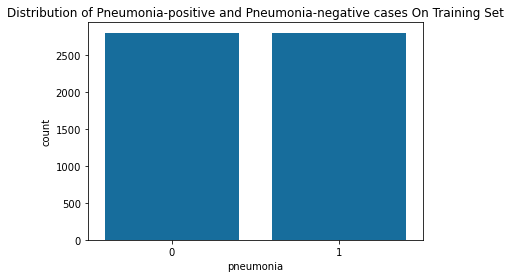

In [14]:
sns.countplot(df_train['pneumonia'], color=base_color)

plt.title('Distribution of Pneumonia-positive and Pneumonia-negative cases On Training Set')

plt.show()

In [15]:
training_data_filepath = os.path.join('.', "train_data.csv")
df_train.to_csv (training_data_filepath, index = True, header = True)

# Generate Validation Set

In [16]:
validation_size = int(np.rint(df_train.shape[0] * 0.2))

pneumonia_size_in_validation = int(np.rint(validation_size * 0.25))
nonpneumonia_size_in_validation = validation_size - pneumonia_size_in_validation

In [17]:
pneumonia_cases_not_in_sample = pneumonia_cases_not_in_sample.sample(frac=1).reset_index(drop=True)
pneumonia_cases_in_validation = pneumonia_cases_not_in_sample.sample(pneumonia_size_in_validation)

In [18]:
nonpneumonia_cases_not_in_sample = nonpneumonia_cases_not_in_sample.sample(frac=1).reset_index(drop=True)
nonpneumonia_cases_in_validation = nonpneumonia_cases_not_in_sample.sample(nonpneumonia_size_in_validation)

In [19]:
df_validation = pd.concat([pneumonia_cases_in_validation, nonpneumonia_cases_in_validation])

df_validation = df_validation.sample(frac=1).reset_index(drop=True)

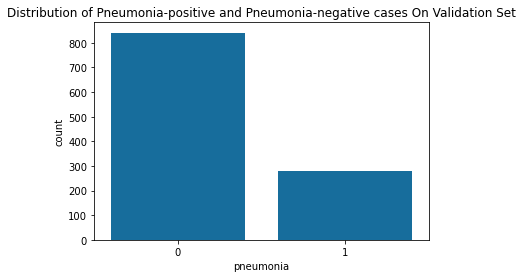

In [20]:
sns.countplot(df_validation['pneumonia'], color=base_color)

plt.title('Distribution of Pneumonia-positive and Pneumonia-negative cases On Validation Set')

plt.show()

In [21]:
validation_data_filepath = os.path.join('.', "validation_data.csv")
df_validation.to_csv (validation_data_filepath, index = True, header = True)

# Generate Testing Set

In [22]:
training_size, validation_size

(5606, 1121)

In [23]:
remaining_pneumonia_cases = pneumonia_cases_not_in_sample[
    ~pneumonia_cases_not_in_sample.image_index.isin(pneumonia_cases_in_validation.image_index)]
remaining_nonpneumonia_cases = nonpneumonia_cases_not_in_sample[
    ~nonpneumonia_cases_not_in_sample.image_index.isin(nonpneumonia_cases_in_validation.image_index)]

In [24]:
pneumonia_cases_in_testing = remaining_pneumonia_cases.copy()

In [25]:
nonpneumonia_size_in_testing = pneumonia_cases_in_testing.shape[0] * 4

In [26]:
remaining_nonpneumonia_cases = remaining_nonpneumonia_cases.sample(frac=1).reset_index(drop=True)

nonpneumonia_cases_in_testing = remaining_nonpneumonia_cases.sample(nonpneumonia_size_in_testing)

In [27]:
df_testing = pd.concat([pneumonia_cases_in_testing, nonpneumonia_cases_in_testing])

df_testing = df_testing.sample(frac=1).reset_index(drop=True)

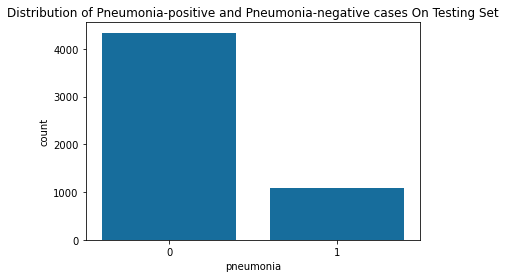

In [28]:
sns.countplot(df_testing['pneumonia'], color=base_color)

plt.title('Distribution of Pneumonia-positive and Pneumonia-negative cases On Testing Set')

plt.show()

In [29]:
testing_data_filepath = os.path.join('.', "testing_data.csv")
df_testing.to_csv (testing_data_filepath, index = True, header = True)